# Generative chatbots with seq2seq models

Chatbot that generates a response instead of selecting from existing ones. There are closed domain chatbots and open domain chatbots. Closed domain chatbot is a chatbot that responses with predefined texts. A generative chatbot generates a response.

## Introduction to seq2seq approach for creating generative chatbots

The seq2seq model also called the encoder-decoder model uses Long Short Term Memory- LSTM for text generation from the training corpus. The seq2seq model is also useful in machine translation applications. What does the seq2seq or encoder-decoder model do in simple words? 

It predicts a word given in the user input and then each of the next words is predicted using the probability of likelihood of that word to occur.

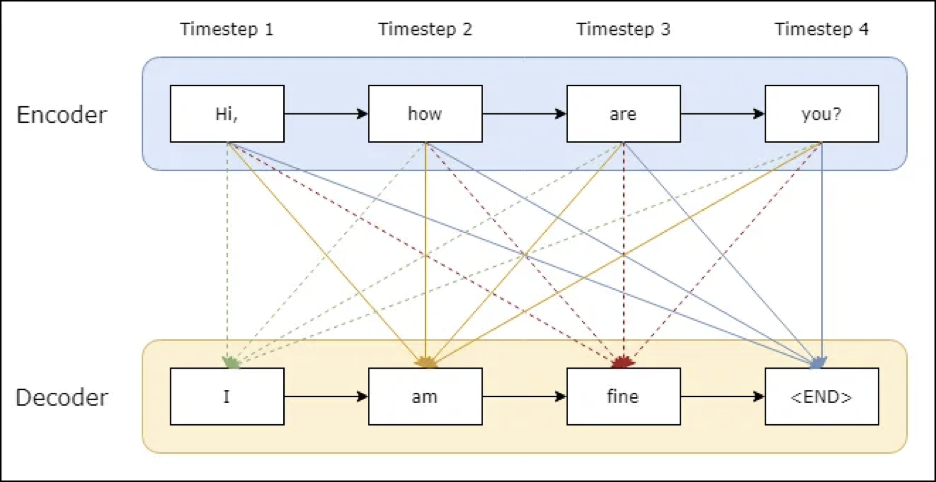

The encoder outputs a final state vector (memory) which becomes the initial state for the decoder. We use a method called **teacher forcing** to train the decoder which enables it to predict the following words in a target sequence given in the previous words. As shown above, states are passed through the encoder to each layer of the decoder. ‘Hi,’, ‘how’, ‘are’, and ‘you’ are called input tokens while ‘I’, ‘am’, and ‘fine’ are called target tokens. The likelihood of token ‘am’ depends on the previous words and the encoder states. We are adding $\text{'<END>'}$ token to let our decoder know when to stop.

Let’s start building our generative chatbot from scratch! The first task we will have to do is preprocess our dataset.


In [ ]:
import re
import random
from keras.models import load_model
import numpy as np
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model




In [ ]:
data_path = "human_text.txt"
data_path2 = "robot_text.txt"

# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().split('\n')

In [ ]:
lines = [re.sub(r"\[\w+\]",'hi',line) for line in lines]
lines = [" ".join(re.findall(r"\w+",line)) for line in lines]
lines2 = [re.sub(r"\[\w+\]",'',line) for line in lines2]
lines2 = [" ".join(re.findall(r"\w+",line)) for line in lines2]

# grouping lines by response pair
pairs = list(zip(lines,lines2))
random.shuffle(pairs)

In [ ]:
pairs[:5]

We will have to create separate lists for input sequences and target sequences and we will also need to create lists for unique tokens (input tokens and target tokens) in our dataset. For target sequences, we will add ‘$<START>$’ at the beginning of the sequence and ‘$<END>$’ at the end of the sequence so that our model knows where to start and end text generation. We will do this as shown below.

In [ ]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs[:400]:
  input_doc, target_doc = line[0], line[1]
  input_docs.append(input_doc)

  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)

  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

**Note:** We are only taking the first 400 pairs to keep things simple but as a result, we will get very low accuracy.

We have unique input tokens and target tokens for our dataset. Now we will create an input features dictionary that will store our input tokens as key-value pairs, the word being the key and value is the index. Similarly, for target tokens, we will create a target features dictionary. 

Features dictionary will help us encode our sentences into one-hot vectors. After all, computers only understand the numbers. To decode the sentences we will need to create the reverse features dictionary that stores index as a key and word as a value.

In [ ]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])
reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

### Training setup

To train our seq2seq model we will use three matrices of one-hot vectors, Encoder input data, Decoder input data, and Decoder output data. 

The reason we are using two matrices for the Decoder is a method called **teacher forcing** which is used by the seq2seq model while training. We have an input token from the previous timestep to help the model train for the current target token. Let’s create these matrices.


In [ ]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros((len(input_docs), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

### Encoder-decoder training setup

Our encoder model requires an input layer which defines a matrix for holding the one-hot vectors and an LSTM layer with some number of hidden states. Decoder model structure is almost the same as encoder’s but here we pass in the state data along with the decoder inputs.

In [ ]:
dimensionality = 256

batch_size = 10
epochs = 600

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### Building and training seq2seq model
Now we will create our seq2seq model and train it with encoder and decoder data as shown below.

In [ ]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
# training_model.save('training_model.h5')

### Testing setup
Now, to handle an input that the model has not seen we will need a model that decodes step-by-step instead of using teacher forcing because the model we created only works when the target sequence is known. 

In the Generative chatbot application, we will not know what the generated response will be for input the user passes in. For doing this, we will have to build a seq2seq model in individual pieces. Let’s first build an encoder model with encoder inputs and encoder output states. We will do this with the help of the previously trained model.


In [ ]:
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

Next, we will need to create placeholders for decoder input states as we do not know what we need to decode or what hidden state we will get.

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

Now we will create new decoder states and outputs with the help of decoder LSTM and Dense layer that we trained earlier.

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

Finally, we have the decoder input layer, the final states from the encoder, the decoder outputs from the Dense layer of the decoder, and decoder output states which is the memory during the network from one word to the next. We can bring this all together now and set up the decoder model as shown below.

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

### Testing our model
At last, we will create a function that accepts our text inputs and generates a response using encoder and decoder that we created. In the function below, we pass in the NumPy matrix that represents our text sentence and we get the generated response back from it. I have added comments for almost every line of code for you to understand it quickly. What happens in the below function is this: 1.) We retrieve output states from the encoder 2.) We pass in the output states to the decoder (which is our initial hidden state of the decoder) to decode the sentence word by word 3.) Update the hidden state of decoder after decoding each word so that we can use previously decoded words to help decode new ones
We will stop once we encounter ‘<END>’ token that we added to target sequences in our preprocessing task or we hit the maximum length of the sequence.

In [ ]:
def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
while not stop_condition:
      #Predicting output tokens with probabilities and states
      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
#Choosing the one with highest probability
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      decoded_sentence += " " + sampled_token
#Stop if hit max length or found the stop token
      if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True
#Update the target sequence
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      #Update states
      states_value = [hidden_state, cell_state]
return decoded_sentence

### Putting it all together — Generative Chatbot

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")

#Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)

#Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)

    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

### Future scope vs limitation
Here we used a very small dataset and got an accuracy of around 20%. In the future for a larger dataset, the model might give better accuracy. The limitation of using this approach for creating chatbots is that we need a very large dataset to give the best responses to the user. The chatbot may not give the right responses in some cases because of a smaller dataset.

### Conclusion
Closed domain systems use intent classification, entity identification, and response selection. But for an open domain chatbot, intent classification is harder and an immense number of intents are likely. Rather than selecting full responses, the open domain or generative model generates the response word by word, allowing for new combinations of language. In industries, some companies use the closed domain chatbots to ensure that the user always receives the right response from the predefined ones.